In [1]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from cleaning_script import NOMINAL, ORDINAL, CONTINUOUS, DISCRETE, return_plot, plot_important_features, run_regression
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 4. - Regression Modeling Notebook
---

### Project Contents

1. [Data Cleaning](../code/data_cleaning.ipynb) 
2. [Data Correlation](../code/data_correlation.ipynb) 
3. [Data Visualization](../code/visualizations.ipynb)
4. [Regression Model Comparison](../code/regression_model.ipynb) [This Notebook]
5. [Function Library](../code/cleaning_script.py) (*In an effort to reduce clutter, many custom data cleaning and visualization functions are consolidated here*)
---

### Notebook Purpose

This notebook uses the cleaned and improved data that has been iterated upon through the three preceding notebooks and fits various regression models in an effort to develop a linear regression model with robust predictive power. We will explore four different regression methods.

The four regression models are broadly similar but are different in their treatment of coefficients:

### Lasso Regression
$$ \text{minimize:}\; RSS + Lasso = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \lambda_1\sum_{j=1}^p |\beta_j|$$

**Where:**

$|\beta_j|$ is the absolute value of the $\beta$ coefficient for variable $x_j$

$\lambda_1$ is again the strength of the regularization penalty component in the loss function. In lasso the lambda is denoted with a 1, in ridge the lambda is denoted with a 2.


Lasso standard for Least Absolute Shrinkage Selector Operator, and assigns a penalty to coefficients in the linear model using the above formula. Effectively, it penalizes the coefficients the model overemphasizes and reduces the possibility of overfitting.

### Ridge Regression
$$ \text{minimize:}\; RSS+Ridge = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \lambda_2\sum_{j=1}^p \beta_j^2$$

**Where:**

$\beta_j^2$ is the squared coefficient for variable $x_j$.

$\sum_{j=1}^n \beta_ij^2$ is the sum of these squared coefficients for every variable we have in our model. This does **not** include the intercept $\beta_0$.

$\lambda_2$ is a constant for the _strength_ of the regularization parameter.

Ridge assigns a penalty to the coefficients based on the squared magnitude of the coefficient, multiplied by $\lambda$. Much like Lasso regression, ridge penalizes overemphasised coefficients.

### Elastic Net
$$
\text{minimize:}\; RSS + Ridge + Lasso = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \lambda_1\sum_{j=1}^p |\beta_j| + \lambda_2\sum_{j=1}^p \beta_j^2$$
Elastic net is Lasso and Ridge Regression combined, reducing the impact of some features but not eliminating them.

### Ordinary Least Squares

$$ \text{minimize:}\; RSS = \sum_{i=1}^n (y_i - \hat{y}_i)^2 = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 $$

Where our model predictions for $y$ are based on the sum of the $beta_0$ intercept and the products of $\beta_i$ with $x_i$.

We will evaluate the efficacy of our models by splitting the data into training and validation sets, training the models on the training data and then testing on the validation data. By employing training, validation and cross validation we can build out a robust model and endeavor to avoid overfitting to the provided dataset.


### Regression Diagnostics

While we have taken care to cull the Ames dataset for features that have potential predictive power, this has introduced the potential for severe multicollinearity. Fortunately, our client *desires a model of robust predictive power* at the expense of inferential power, so we can worry less about coefficient interpretation than we would normally. However, we will screen for and attempt to reduce multicollinearity wherever possible. 

### Scoring

We will evaluate the different models with two metrics, Root Mean Square Error (RMSE) and $R^2$ or the Coefficient of Determination. RMSE is a measure of the average difference between the predicted values of the dependent variable and the actual values, and is calculated by taking the square root of the average of the squared differences between the predicted and actual values of the dependent variable. Thus, this is the average of the errors in the model, in the unit of the target variable. $R^2$ is a measure of the proportion of the variance in the dependent variable that is explained by the independent variables in the model, and is calculated by taking the ratio of the sum of the squared differences between the predicted and actual values of the dependent variable (the "residual sum of squares") to the total sum of squares of the dependent variable and it holds a value between $0$ and $1$.

---

Read in clean .CSV data

In [2]:
%store -r correlative_factors
%store -r outlier_cols
correlative_factors.pop('saleprice', None)

# training data
house_train = pd.read_csv('../datasets/house_train_improved.csv')
# testing data
house_test = pd.read_csv('../datasets/house_test_improved.csv')
# increase column width
pd.set_option('display.max_columns', 300)

In [3]:
drop = []
correlative_factors = {k:v for k,v in correlative_factors.items() if v not in drop}
FEATURES = correlative_factors.keys()
FEATURES = [x for x in correlative_factors.keys() if x not in drop]
FEATURES+= outlier_cols

In [4]:
X = house_train[FEATURES]
y = house_train.saleprice
X_test = house_test[FEATURES]

X_train, X_val, y_train, y_val = train_test_split(X, y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())
Xs_val = pd.DataFrame(ss.transform(X_val), columns = ss.get_feature_names_out())

# I. First Iteration
### Model Performance with All Features and NO Transformations

We first establish a baseline
The baseline is calculated using the mean of all salesprice values, so if our model cannot get a lower RMSE than our baseline, our model is useless. 

In [5]:
base = [y_train.mean()]*len(y_train)
# get baseline rmse
print('Baseline RMSE:', np.sqrt(mean_squared_error(y_train, base)))

Baseline RMSE: 78676.64736757238


OLS

Training R^2 Score:  0.8797644292297963
Training RMSE:  27281.128412949252
Cross Validation R^2 Score:  0.8502834954669545
Validation R^2 Score 0.8231983298126286

Lasso

Training R^2 Score:  0.8797206585211383
Training RMSE:  27286.093689277346
Cross Validation R^2 Score:  0.8507816725664334
Validation R^2 Score 0.8228636815893136

Ridge

Training R^2 Score:  0.8797340846136744
Training RMSE:  27284.570751763094
Cross Validation R^2 Score:  0.8507364955460884
Validation R^2 Score 0.8229228261403536

Elastic Net

Training R^2 Score:  0.8797456076846112
Training RMSE:  27283.263608444162
Cross Validation R^2 Score:  0.8505858986282341
Validation R^2 Score 0.8229884613442321



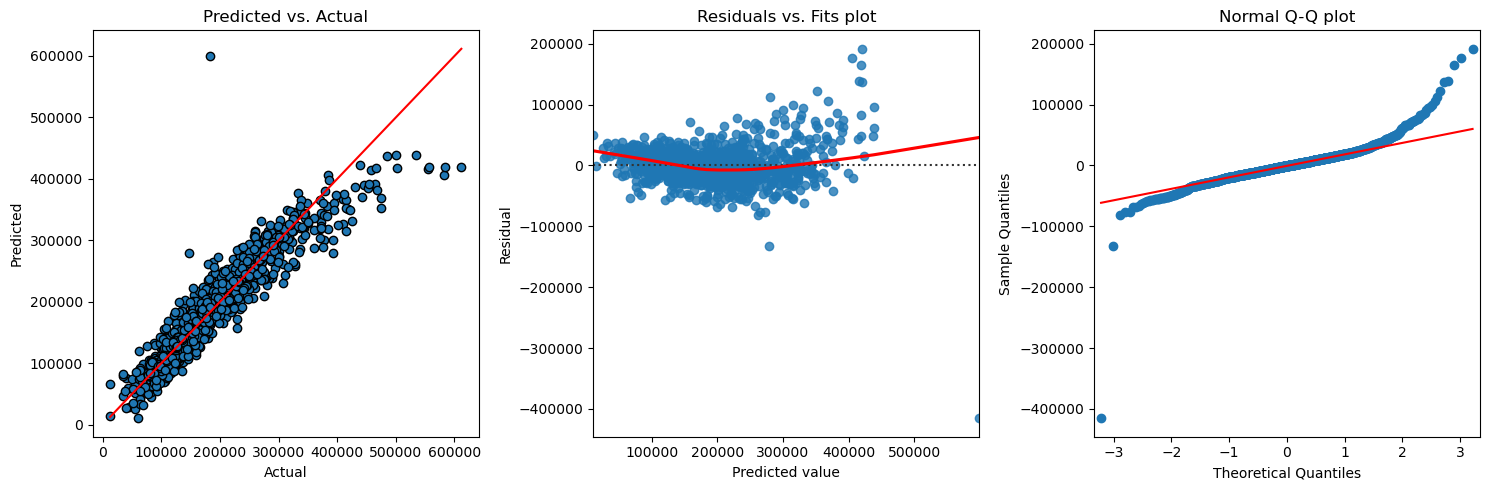

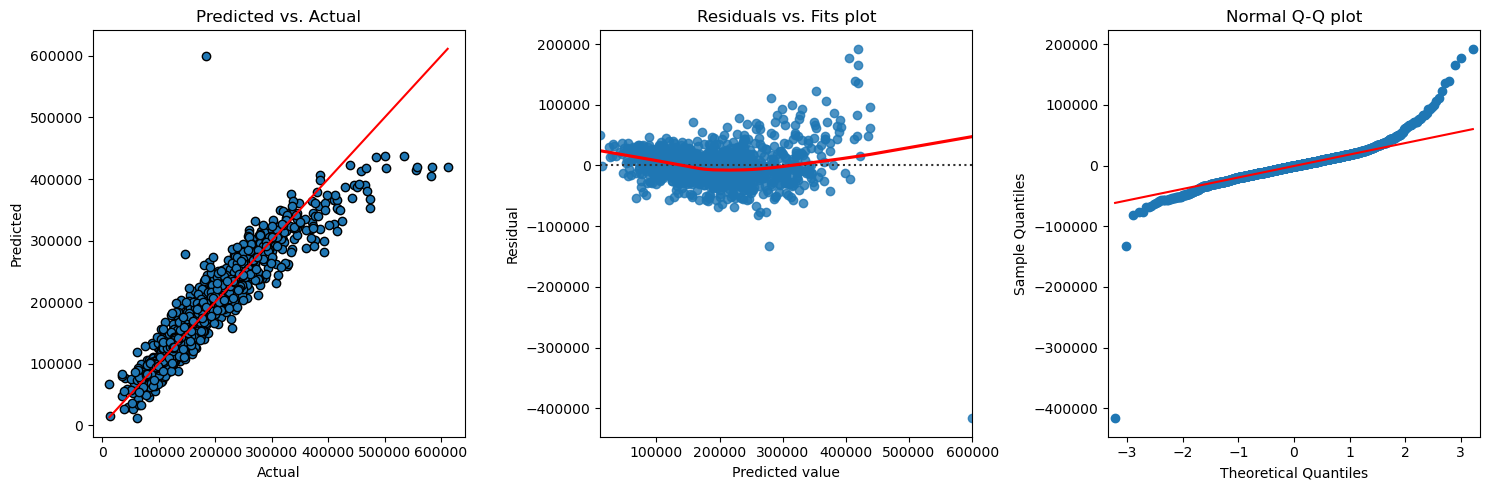

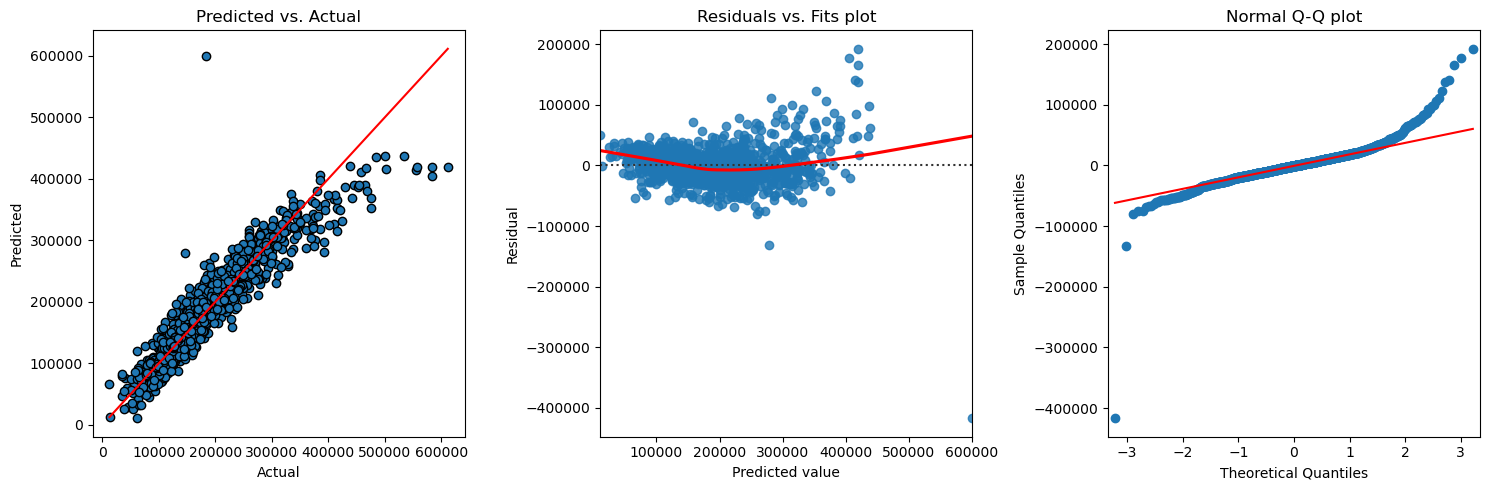

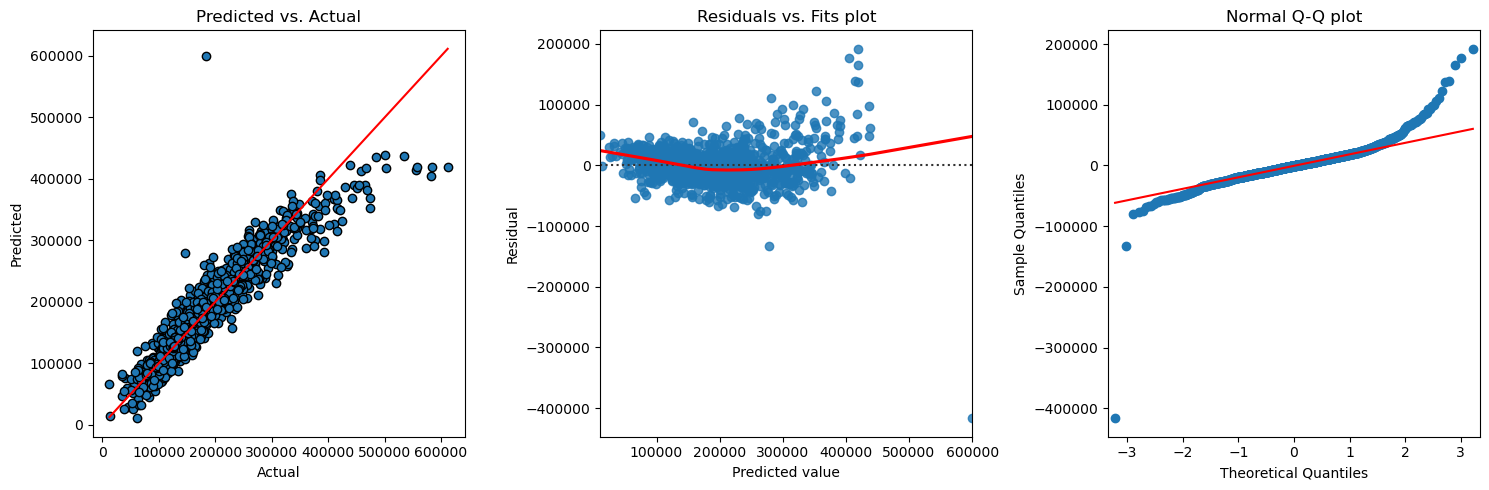

In [6]:
run_regression(X_train, X_val, Xs_train, Xs_val, y_train, y_val, standardize = False, log_flag = False)

Text(0.5, 1.0, 'Influence Plot')

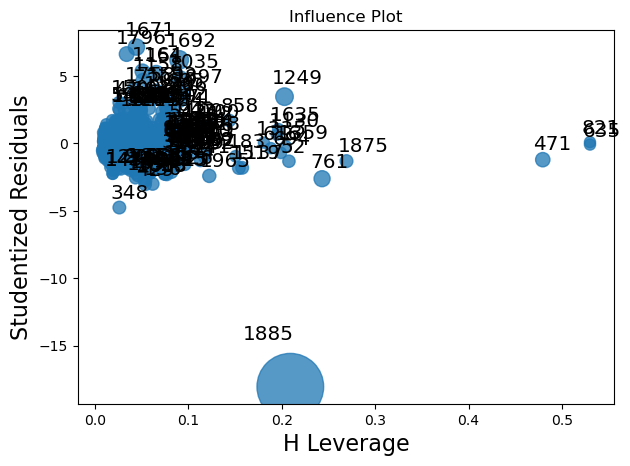

In [7]:
# fit stats models OLS
Xs_train = sm.add_constant(X_train)
Xs_val = sm.add_constant(X_val)
model = sm.OLS(y_train, X_train)
results = model.fit()


fig = sm.graphics.influence_plot(results, criterion="cooks", title='Influence Plot')
fig.tight_layout(pad=1.0)
plt.title('Influence Plot')


The above "influence" plot shows the effect of outliers on the regression model. The size of the dots is proportional to "cook's value". 

The Cook's value of an observation is calculated by fitting the regression model to the data, and then removing the observation in question and refitting the model. The Cook's value is then calculated as the sum of the squared differences between the predicted values of the dependent variable for the two models. A large Cook's value indicates the potential presence of an outlier. [SOURCE](https://www.statisticshowto.com/cooks-distance/)

### First Iteration Notes


Without transforming the features in any way, we see that the model performs O.K. 

**Interpretation** 

Of note is the consistency in scores between the four types of linear regression. All of our training $R^2$ scores are around $.88$ meaning our model accounts for $.88$ of the variance in the training data, however our validation $R^2$ falls to $.81$. The Root Mean Squared Error is consistent across all four models, at ~ $27,000$, meaning our model errors in prediction by an average of $27,000.

However, while the initial $R.M.S.E.$ and $R^2$ scores are far better than the naive prediction, there is much room for improvement. 

We see a difference between our training, cross validation and validation scores for all four models. Additionally, the diagnostic plots for each model presented above show that our model is still struggling with outliers. The residuals vs. fits plots show that linearity seems to hold up O.K., as the red line is close to the dashed line but there is still with some curvature. The QQ plots show that our residuals are fairly close to being normally distributed, but that there is some clear non-linearity in our model. 

**Outliers** 

The predicted vs. actual scatter plots for the two sets of regression diagnostic plots show that severe outliers are interfering with our model's predictive power. We note in the provided data dictionary the following: 

    SPECIAL NOTES:
    There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students.

We will heed the author's advice and remove rows with a gross living area value > $4,000$ square feet. 

Additionally, we note the that the influence plot shows that two observations are exhibiting great influence, as measured by Cook's Value. We see that the entries at indices 635, 960 and 1885 are true outliers with heavy influence and we will remove them as well. 

With these results in mind, we will implement the Log and Sqrt Transformations we considered in the third notebook and run our regression models again. 

# II. With Log and Sqrt Transformations

In [8]:
house_train = pd.read_csv('../datasets/house_train_improved.csv')
house_test = pd.read_csv('../datasets/house_test_improved.csv')
# drop 635, 960, 1885
house_train = house_train.drop([471,635, 821, 960, 1875, 1885])
house_train = house_train.query('gr_liv_area < 4000')


In [9]:
### Feature Transformation

sqrt_vars = ['total_bsmt_sf', 'house_age', 'garage_age']
for col in sqrt_vars:
    house_train[col] = np.sqrt(house_train[col])
    house_test[col] = np.sqrt(house_test[col])

log_vars = ['lot_area', 'lot_frontage', 'gr_liv_area']
for col in log_vars:
    house_train[col] = np.log(house_train[col])
    house_test[col] = np.log(house_test[col])
    

In [10]:
house_train.saleprice = np.log(house_train.saleprice)
log_flag = True

In [11]:
FEATURES = correlative_factors.keys()
FEATURES = [x for x in correlative_factors.keys() if x not in drop]
FEATURES+= outlier_cols

X = house_train[FEATURES]
y = house_train.saleprice
X_test = house_test[FEATURES]

X_train, X_val, y_train, y_val = train_test_split(X, y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())
Xs_val = pd.DataFrame(ss.transform(X_val), columns = ss.get_feature_names_out())

OLS

Training R^2 Score:  0.914352706043309
Training RMSE:  22106.145119469744
Cross Validation R^2 Score:  0.9026946277378041
Validation R^2 Score 0.8914955991358208

Lasso

Training R^2 Score:  0.9137401296286536
Training RMSE:  22355.3894764069
Cross Validation R^2 Score:  0.9035502578092551
Validation R^2 Score 0.893545162844868

Ridge

Training R^2 Score:  0.914352651787449
Training RMSE:  22099.263327763754
Cross Validation R^2 Score:  0.9027250697281198
Validation R^2 Score 0.8915610333212955

Elastic Net

Training R^2 Score:  0.91416907875381
Training RMSE:  22207.881230305535
Cross Validation R^2 Score:  0.9033528786662407
Validation R^2 Score 0.8928382714471896



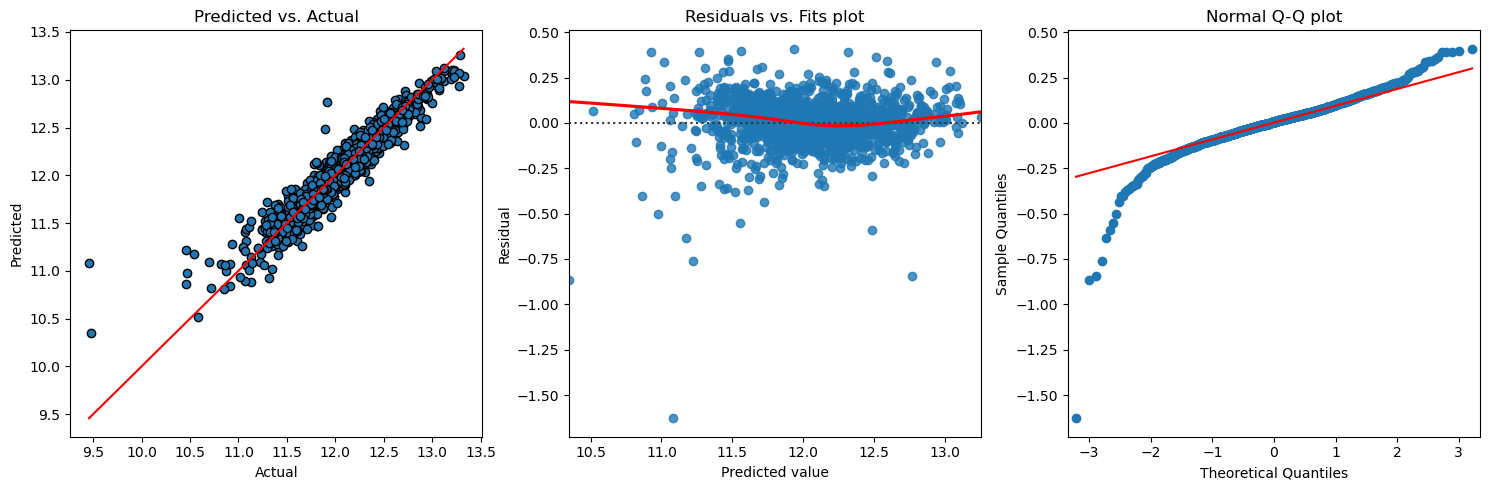

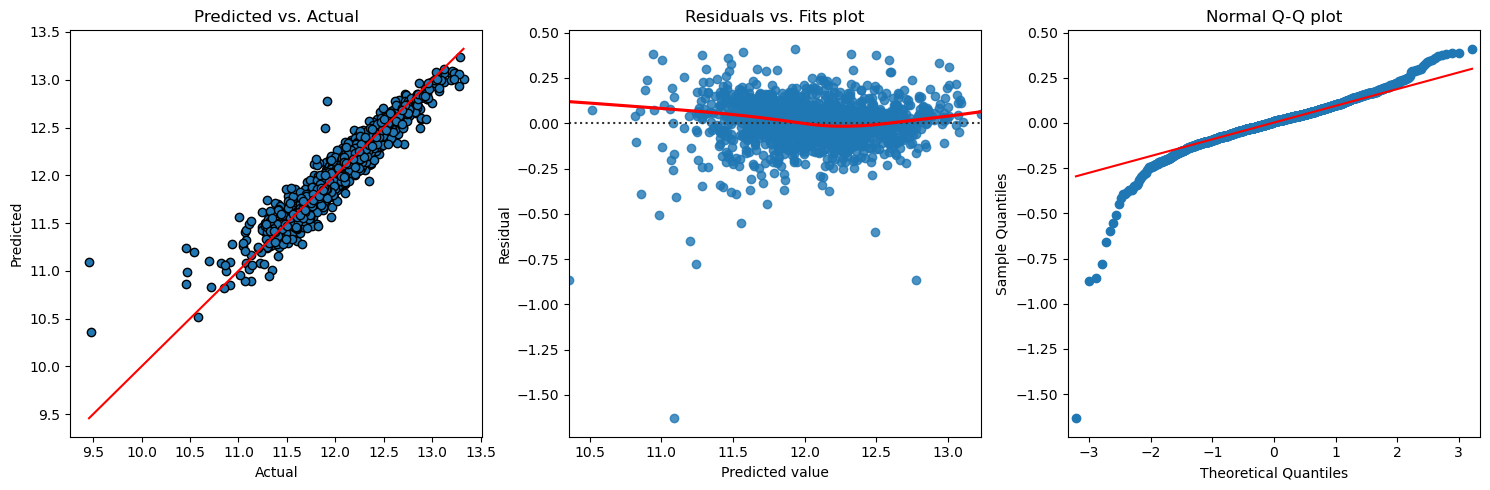

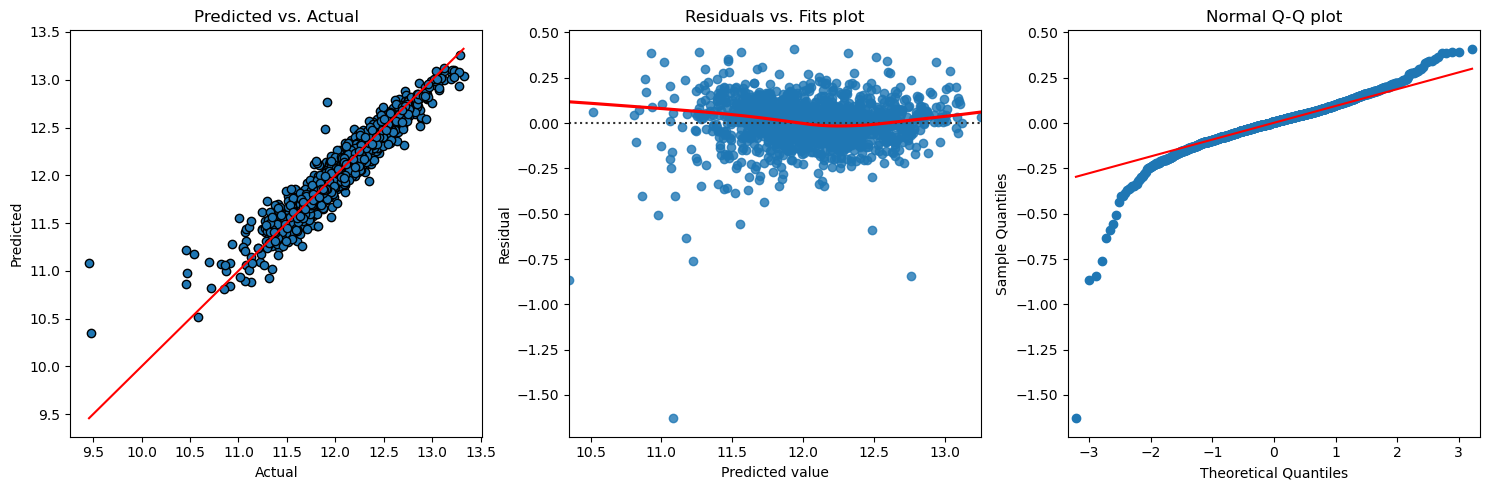

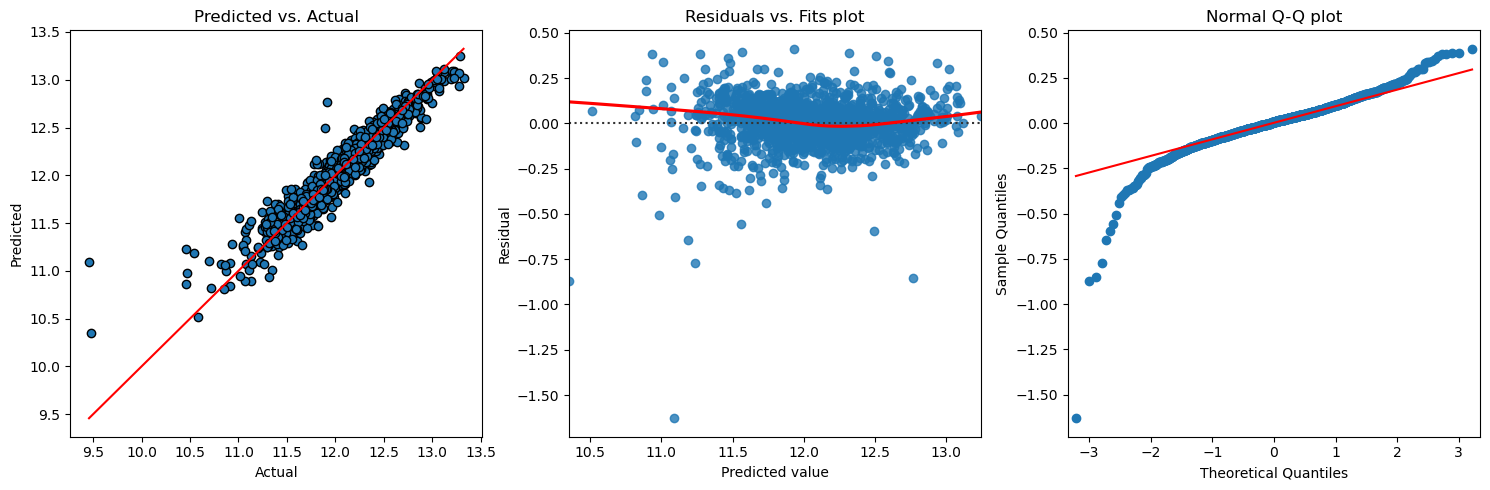

In [12]:
run_regression(X_train, X_val, Xs_train, Xs_val, y_train, y_val, standardize = True, log_flag = True)

### Second Iteration Notes

**Interpretation**

The results above are encouraging. We see that the Log and Sqrt feature transformations have returned higher $R^2$ scores across the training, cross validation and validation metrics. The R.M.S.E. scores are all lower, and the diagnostic plots show that the model is fitting better and that the residuals are more normally distributed. Our first iteration model was underestimating the higher priced homes, but now that we have have created a log linear model we see that the we are getting a better fit for both the lower and higher prices homes. The residuals vs. fits plots shows better but still not perfect linearity, and the QQ plot looks mostly good - a perfectly normal distribution would have the scatter points exactly on the red line. 

**Transformation and Interpretation**

By transforming six of our features as well as the target variable we have improved the performance of our model, but at a cost. It is not difficult to interpret the coefficients of our linear model, and we have lost inferential power. In the cases where our features are log-transformed, we interpret the coefficient as the proportional change in the dependent variable associated with a unit increase in the independent variable. For our features that are not log-transformed, since the target variable *is* log transformed, we must divide the coefficient by $100$, which tells us that a 1% increase in the independent variable increases (or decreases) the dependent variable by (coefficient/100) units. [SOURCE](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/).

**Polynomial Regression**

We found earlier that gross living area and overall quality and condition of the home had the highest Pearson correlation coefficients with respect to sale price. In our final iteration, We will square these values and see if the extra weight provides a better fit. 


# III. Third Iteration
### Log and Square Root Transformations, Polynominal Transformations of Features, Outliers Removed

In [13]:
house_train = pd.read_csv('../datasets/house_train_improved.csv')
house_test = pd.read_csv('../datasets/house_test_improved.csv')
# drop 635, 960, 1885
house_train = house_train.drop([471, 635, 821, 960, 1885, 1875])
house_train = house_train.query('gr_liv_area < 4000')
drop = []

### Polytransformation

In [14]:
poly_columns = ['gr_liv_area', 'overall_qual_cond']   
def poly_features(df):
    for x in poly_columns:
        df[x+'_poly'] = df[x]**2
poly_features(house_train)
poly_features(house_test)
# add '_poly to poly_columns
poly_columns = [x+'_poly' for x in poly_columns]

In [15]:
### Feature Transformation

sqrt_vars = ['total_bsmt_sf', 'house_age', 'garage_age']
for col in sqrt_vars:
    house_train[col] = np.sqrt(house_train[col])
    house_test[col] = np.sqrt(house_test[col])

log_vars = ['lot_area', 'lot_frontage', 'gr_liv_area']
for col in log_vars:
    house_train[col] = np.log(house_train[col])
    house_test[col] = np.log(house_test[col])
    

In [16]:
house_train.saleprice = np.log(house_train.saleprice)
log_flag = True

In [17]:
FEATURES = correlative_factors.keys()
FEATURES = [x for x in correlative_factors.keys() if x not in drop]
FEATURES+= poly_columns + outlier_cols

X = house_train[FEATURES]
y = house_train.saleprice
X_test = house_test[FEATURES]

X_train, X_val, y_train, y_val = train_test_split(X, y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())
Xs_val = pd.DataFrame(ss.transform(X_val), columns = ss.get_feature_names_out())

OLS

Training R^2 Score:  0.908075039110027
Training RMSE:  21849.184292917915
Cross Validation R^2 Score:  0.8937142455314724
Validation R^2 Score 0.9209297353869141

Lasso

Training R^2 Score:  0.9076760571814795
Training RMSE:  21950.504141091504
Cross Validation R^2 Score:  0.8958662321064331
Validation R^2 Score 0.9219765964907952

Ridge

Training R^2 Score:  0.908273709368514
Training RMSE:  21770.142737288632
Cross Validation R^2 Score:  0.8938095228969342
Validation R^2 Score 0.921295433578024

Elastic Net

Training R^2 Score:  0.9080840962467813
Training RMSE:  21832.26584274325
Cross Validation R^2 Score:  0.8952761212917484
Validation R^2 Score 0.9217491184692309



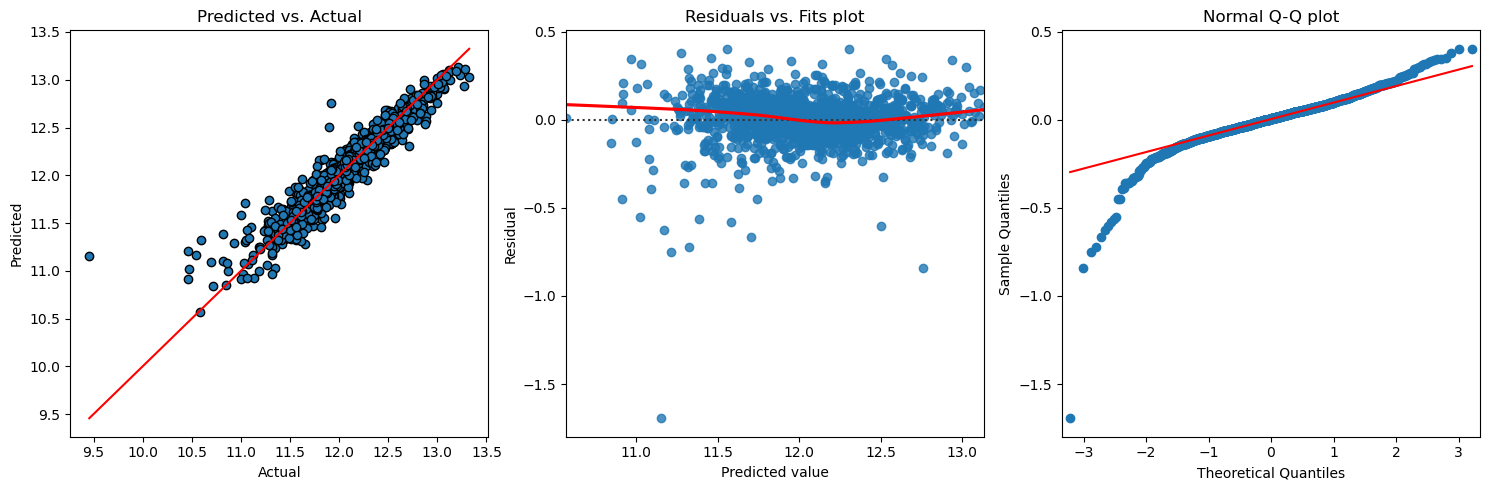

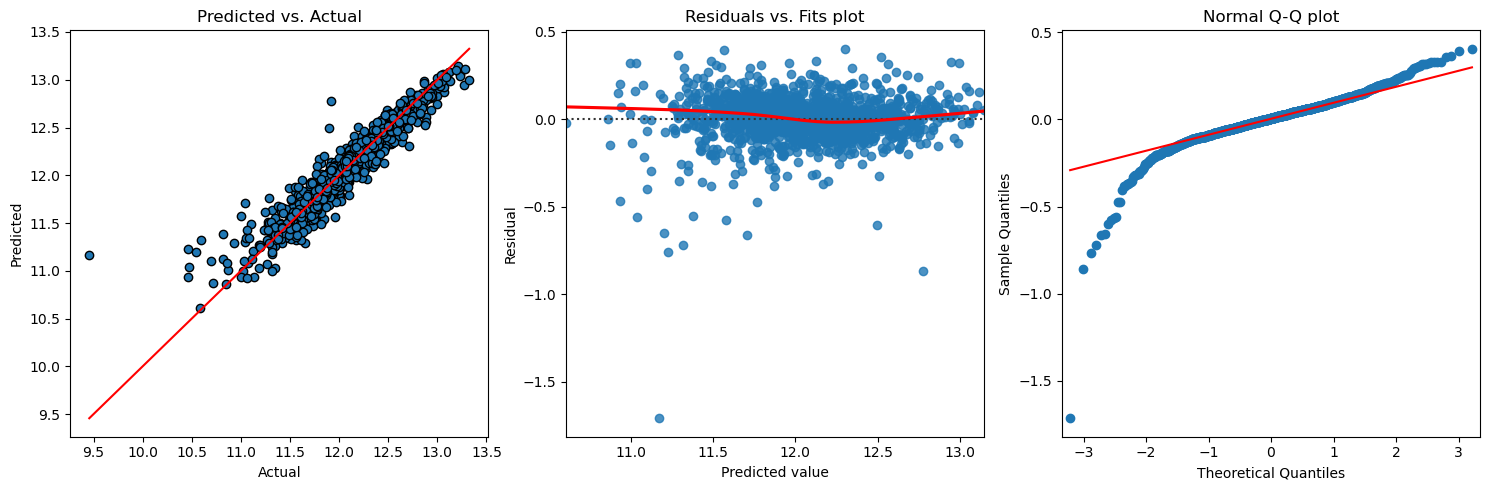

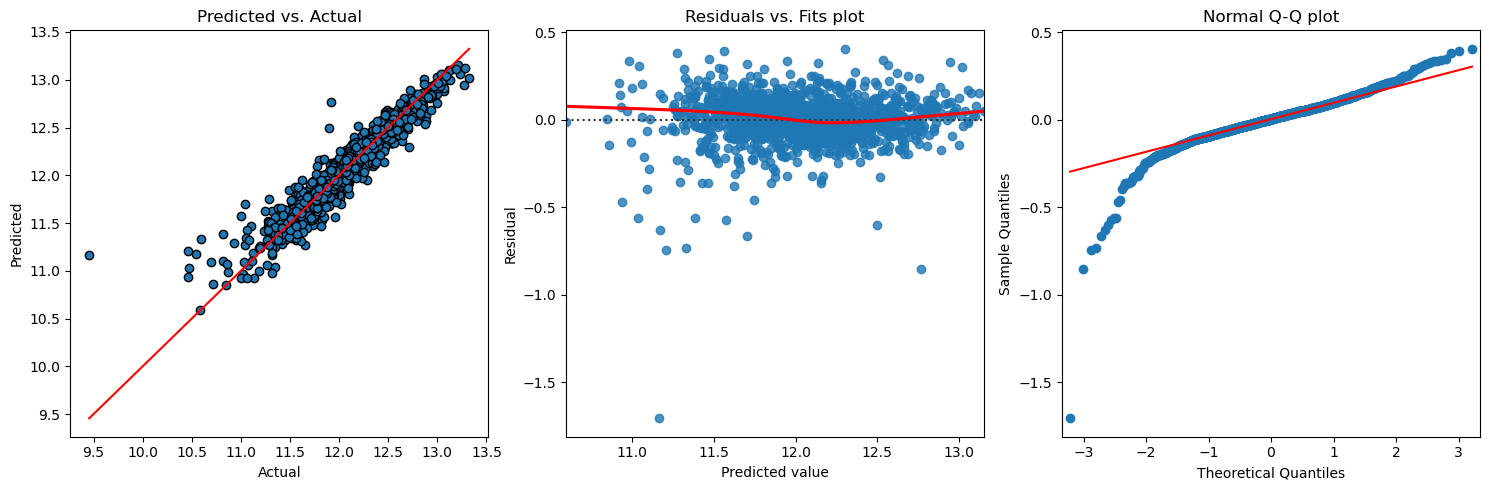

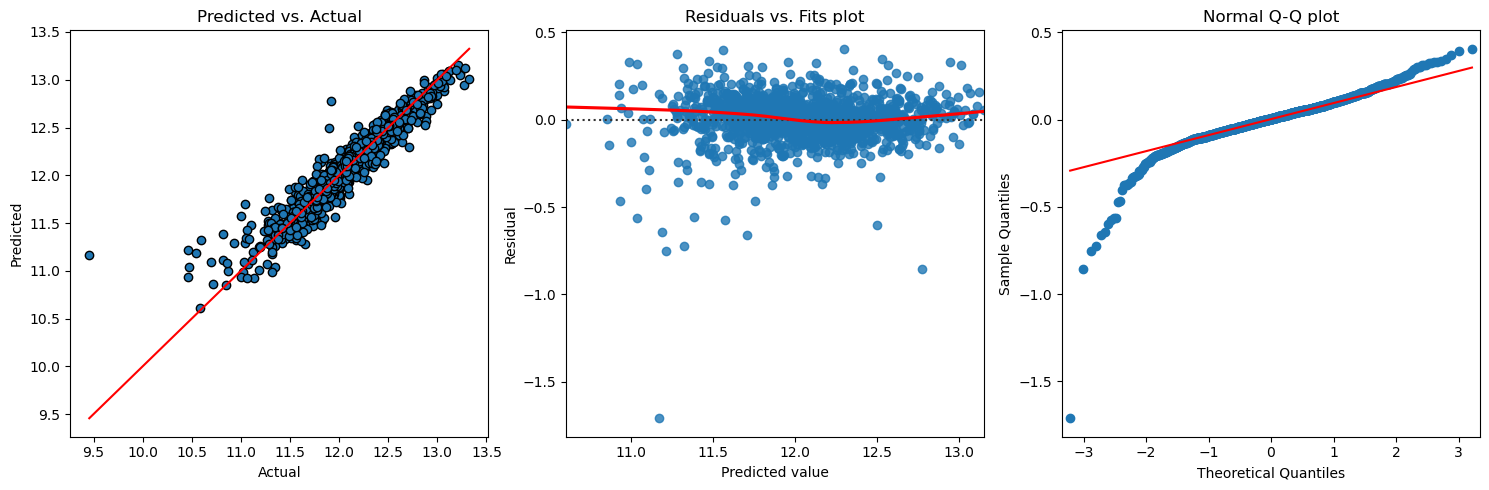

In [18]:
run_regression(X_train, X_val, Xs_train, Xs_val, y_train, y_val, standardize = True, log_flag = True)

### Third Iteration Notes

The results are similar to the second iteration, but the model is performing a bit better when evaluated by RMSE and $R^2$. We see that our training, cross validation and validation scores $R^2$ scores are all around .90~.91 which means our model is generalizing well and showing consistency. The regression diagnostic plots show that the influence of outlier values has been tamped down a bit more and that the model is as linear as we can get it without re-configuring our process. 

Of the four different linear models, Lasso is performing the best, with the highest Cross Validation score across the three iterations, so we will use Lasso for our final production model and Kaggle Submission. 

---

# IV. Testing Linear Assumptions

Regression models need to meet certain requirements to be effective, we call these linear assumptions. The assumptions are:

1. Linearity: The relationship between the dependent and independent variables is linear.

2. Independence of Errors: The residuals in the model are independent and identically distributed. This means that the errors in the model are uncorrelated with each other and have a constant variance.

3. Normality: The residuals are normally distributed. This means that the distribution of the errors in the model follows a normal distribution. 

4. Equality of Variance: The errors in the model are homoscedastic. This means that the variance of the errors is constant.

5. No Multicollinearity: The independent variables are not highly correlated with each other. This means that the independent variables should be relatively independent of one another, and should not be strongly correlated.

We tested for the first three conditions with our regression diagnostic plots. The model is not perfectly linear but we have taken great steps towards improving it's linearity via feature transformation. Our 'fits vs. residuals' plots show that the model is mostly linear and also indicate that we have independence of errors -- there is no discernable pattern in the residuals plotted. The QQ plots show that we almost meet the Normal distribution however there is some un-addressed non-linear interaction within the model. 

**Durbin Watson Test for Auto Correlation**

The Durbin-Watson test is a statistical test used to detect the presence of autocorrelation, which is the correlation between consecutive residuals, in a regression model. Autocorrelation occurs when the residuals in a regression model are not independent, and can effect accuracy. A Durbin Watson score of 2 indicates that there is no auto correlation in the model. We find that our model has a DW d-value of $2.03$.

In [19]:
# instantiate a stats models OLS model
Xs_train_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, Xs_train_sm)
results = model.fit()

In [20]:

# durbin watson test
from statsmodels.stats.stattools import durbin_watson
durbin_watson(results.resid)


2.030738371540476

The Durbin-Watson test indicates that our model is free of autocorrelation. 

**Multicollinearity**

The process of selecting factors based on correlation to saleprice introduced the possibility of strong multicollinearity into the model, making coefficient interpretation difficult or impossible. We test for multicollinearity in the model by examining the *variance inflation factor* of each feature. If a feature has a VIF over 5, we have severe multicollinearity in the model. 

Variance Inflation Factor

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(Xs_train.values, i) for i in range(Xs_train.shape[1])]
vif["features"] = Xs_train.columns;

vif.query('VIF_Factor > 5')

c:\Users\alexs\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\Users\alexs\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,VIF_Factor,features
3,6.325176,fireplaces
4,6.697935,garage_cars
6,8.655773,lot_area
9,13.968510,gr_liv_area
10,6.172214,garage_area
15,inf,fireplace_qu
46,85.890139,overall_qual_cond
51,13.142035,neighborhood_price_rank
55,15.061502,house_age
56,5.270010,land_house_ratio


Our model has severe multicollinearity. This was expected, as the model's very design was based on factors that correlated strongly with `saleprice`. 

Fortunately, our client has asked for a model that prioritizes *predictive* power over inferential power, which we have surely accomplished. In order to reduce this multicollinearity, we would need to reconsider our model's architecture.

# V. Feature Importance

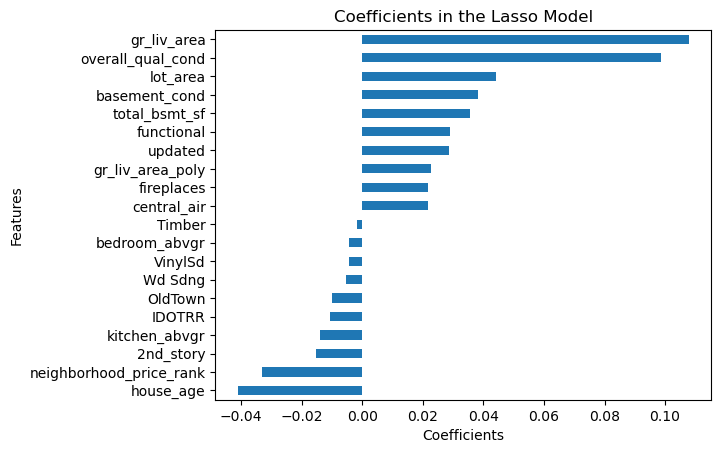

In [26]:
# fit our production model
mlr_lasso = Lasso(alpha=.001)
#calculate residuals by creating predictions
mlr_lasso.fit(Xs_train,y_train)
preds = mlr_lasso.predict(Xs_train)
resid = y_train - preds

plot_important_features(mlr_lasso, Xs_train, 10)

# dataframe of the coefficients
coef_df = pd.DataFrame(mlr_lasso.coef_, index = Xs_train.columns, columns = ['coef'])


By plotting the coefficients we can visualize the the most important features in our model. 

We note the following:

1. Gross living area is the most important feature by far. 
2. The overall quality and condition of the home is the second most important feature. 
3. The age of the home and the time period since remodeling has influence on the sales price
4. Neighborhood location is one of the most important features. 

In [28]:
coef_df.sort_values('coef', ascending = False)

,coef
gr_liv_area,0.107845
overall_qual_cond,0.098764
lot_area,0.044071
basement_cond,0.038320
total_bsmt_sf,0.035450
...,...
IDOTRR,-0.010552
kitchen_abvgr,-0.014038
2nd_story,-0.015086
neighborhood_price_rank,-0.033011


# VI. Conclusions and Recommendations

The final production model has powerful predictive ability and the final deliverable is to the client's specifications. 

The Ames dataset has a dizzying array of features, our production model uses $68$ total features, $21$ of which are enginereed. We found that choosing to proceed with the features most correlated to `saleprice` and exploring various transformations of the data has given our model robust predictive power, however this comes with much multicollinearity and at the expense of inference. On unseen data on the Kaggle data science competition webpage, the above model achieved a R.M.S.E of $20,779.2$ on 70% of the unseen Kaggle data, proving that the model generalizes quite well.

**Inference** 

Our transformed features are difficult to interpret, and our model has multicollinearity. However, an interpretation of 2 of the most important features is as follows:

1. `gr_liv_area` has a coefficient of $.1078$. Since our dependent variable, `saleprice` is log transformed, as is `gr_liv_area`, we interpret this coefficient as: for every 1% in gross living area, sale price increases by $.11$ % Or, for every $x$ percent increase, we can calculate 1.x to the power of the coefficient, subtract 1 and multiply by $100$. So, for every $10%$ increase in gross square footage, sales price increases by $(1.10^{.1078}-1)* 100$ or $\approx 1$ %. [SOURCE](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/).

2. `neighborhood_price_rank` has a coefficient of $-.041$. Since our dependent variable is log-linear, we can exponentiate the coefficient, subtract one from this and multiply by 100. This will give us the percent increase or decrease in the response for every one-unit increase in the independent variable. $exp(-.041)-1)  * 100  =  -4.0$. which means that for every $1$% decrease in neighborhood price rank, sales price falls $4$ %. 



### Final Thoughts and Recommendations

1. Gross square footage, overall home quality, the age of the home and the neighborhood are the most important predictors to use in a hedonic price regression. 

2. Choosing hedonic factors based on correlation to `saleprice` leads to a strong home price predictive ability, but the model will have multicollinearity issues and lose inferential power. 

3. Some of the most important features, `lot_area`, `lot_frontage`, `gr_liv_area`, as well as the target, `saleprice`, will likely require a log transformation in order for the linear model to have robust predictive power. 

4. `house_age` will likely require a square root transformation in order for the linear model to have robust predictive power. 


5. Non-linearity within features must be corrected through polynomial regression, we can see that the model gained enhanced predictive power by squaring `gr_liv_area` and `overall_qual_cond`.

**Post Script**

While the production model returned a $R.M.S.E.$ of below $21,000$ on 70% of the unseen Kaggle test data, the model performed considerably worse on the final 30% of the data, with an $R.M.S.E.$ of just over $24,000$. While this is a good loss function score, it is indicative of variance within our model and over-fitting. Further exploration of our model will be required in order to deliver superior price prediction ability. Potential factors to explore would include:

1. Further exploring polynomial or perhaps spline regression.

2. Substantially modifying the model's architecture in an effort to reduce multicollinearity.


---

# Kaggle Submission

In [23]:
new_lasso = Lasso(alpha = 0.001)
new_lasso.fit(X,y)

ss = StandardScaler()
Xs_test = ss.fit_transform(X_test)
Xs_test = pd.DataFrame(Xs_test, columns = ss.get_feature_names_out())


price_preds = new_lasso.predict(X_test)
house_test['SalePrice'] = np.exp(price_preds)

house_test
house_test[['id', 'SalePrice']].to_csv('../datasets/submission.csv', index = False)

In [24]:
house_test[['id', 'SalePrice']].head()

,id,SalePrice
0,2658,114219.881945
1,2718,166316.418717
2,2414,230177.853539
3,1989,112984.943745
4,625,177818.887842
